In [1]:
%pip install -U scikit-learn
%pip install --user -U nltk
%pip install -U pip setuptools wheel
%pip install -U spacy
!python -m spacy download ru_core_news_lg
%pip install -U joblib
%pip install -U matplotlib



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ------------------------------------ 513.4/513.4 MB 446.3 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# import ml packets

In [2]:
import pandas as pd
import numpy as np
import re
import spacy
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn import naive_bayes
from sklearn.svm import LinearSVC
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn import ensemble
from sklearn.svm import LinearSVC
import joblib
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wgmlgz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wgmlgz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [77]:
class Utils():
    # constructor
    def __init__(self):
        """ Class Constructor """
        self.stop_words = stopwords.words('english')
        unwanted_stopwords = {'no', 'nor', 'not', 'ain', 'aren', "aren't", 'couldn', 'what', 'which', 'who',
                              'whom',
                              'why', 'how', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't",
                              'hasn',
                              "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                              "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                              "wasn't",
                              'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'don', "don't"}

        self.excluded_categories = {'Каталог', 'Для маркетплейса'}
        self.stop_words = [
            ele for ele in self.stop_words if ele not in unwanted_stopwords]
        self.wordnet_lemmatizer = WordNetLemmatizer()
        self.nouns = ['NNP', 'NNPS']
        self.nlp = spacy.load('ru_core_news_lg')
        self.label_encoder = LabelEncoder()

    # Function to read data
    def read_data(self, path, sep=",", usecols=[]):
        """ Function to read the data
        @param path (str): path to the dataset
        @param df (pd.DataFrame): pandas DataFrame.
        """
        return pd.read_csv(path,
                           sep=sep,
                           usecols=usecols)

    # Function to decide main categories
    def generate_label(self, df, top=5):
        """ Function to generate labels
        @param df (pd.DataFrame): input data.
        @param top (int): The number of labels to have.
        """
        df['label'] = df.product_category.apply(
            lambda x: x.strip())
        top_categories = list(df[~df['product_category'].isin(self.excluded_categories)].groupby('label').count().sort_values(
            by='product_category', ascending=False).head(top).index)
        df = df[df['label'].isin(top_categories)]
        return df

    # Function to clean text
    def clean_text(self, text, remove_stopwords=True, lemmatize=True):
        """ Function to clean text
        @param text (str): text to be cleaned
        @param remove_stopwords (bool): To remove stopwords or not.
        @param lemmatize (bool): to lemmatize or not.
        """

        # Remove emails
        text = re.sub('\S*@\S*\s?', '', text)

        # Remove new line characters
        text = re.sub('\s+', ' ', text)

        # Remove distracting single quotes
        text = re.sub("\'", '', text)

        # Remove puntuations and numbers
        text = re.sub('\W', ' ', text)

        # Remove single characters
        text = re.sub('\s+\w\s+^I', ' ', text)

        # Remove accented words
        # text = unicodedata.normalize('NFKD', text).encode(
        #     'ascii', 'ignore').decode('utf-8', 'ignore')

        # remove multiple spaces
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'^\s*|\s\s*', ' ', text).strip()
        text = text.lower()

        if not remove_stopwords and not lemmatize:
            return text

        # Remove unncecessay stopwords
        if remove_stopwords:
            text = word_tokenize(text)
            text = " ".join(
                [word for word in text if word not in self.stop_words])

        # Word lemmatization
        if lemmatize:
            text = self.nlp(text)
            lemmatized_text = []
            for word in text:
                if word.lemma_.isalpha():
                    if word.lemma_ != '-PRON-':
                        lemmatized_text.append(word.lemma_.lower())
            text = " ".join([word.lower() for word in lemmatized_text])
        return text

    # Function to prepare data for the model
    def prepare_data(self, df, test_size=0.2, remove_stopwords=True, lemmatize=True):
        """ Function to prepare data for model.
        @param df (pd.DataFrame): input data.
        @param test_size (float): train-test split ratio.
        """
        df = df.sample(frac=1).reset_index(drop=True)
        df["description"] = df["description"] + df["product_name"]
        description = df['product_name'].apply(lambda x: self.clean_text(
            str(x), remove_stopwords=remove_stopwords, lemmatize=lemmatize))
        
        print('description len:', len(description))
        labels = df['label'].apply(lambda x: self.clean_text(
            str(x), remove_stopwords=remove_stopwords, lemmatize=lemmatize)).values.tolist()
        print('labels len:', len(labels))
        labels = self.label_encoder.fit_transform(labels)
        x_train, x_test, y_train, y_test = train_test_split(description,
                                                            labels,
                                                            test_size=test_size,
                                                            stratify=labels)
        return x_train, x_test, y_train, y_test

    # GENERATE COUNT FEATURES AS VECTORS
    def count_vectorize(self, X_train, X_test, analyzer='word', token_pattern=r'\w{1,}', max_features=10000, ngram_range=(1, 1)):
        """ Function to count vectorize the text data.
        @param X_train (list): list of input train text data.
        @param X_val (list): list of input test text data.
        @param analyzer (string): Whether the feature should be made of word n-gram or character n-grams.(‘word’, ‘char’, ‘char_wb')
        @param token_pattern (string): Regular expression denoting what constitutes a “token”.
        @param max_features (int): Max no. of words to build your vocab.
        @param ngram_range (tuple): The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted.
        @return xtrain_count(list): count vectorized train data.
        @return xvalid_count(list): count vectorized test data.
        """
        if analyzer == 'word':
            count_vect = CountVectorizer(analyzer=analyzer,
                                         token_pattern=token_pattern,
                                         max_features=max_features,
                                         ngram_range=ngram_range)
        else:
            count_vect = CountVectorizer(analyzer=analyzer,
                                         max_features=max_features,
                                         ngram_range=ngram_range)
        count_vect.fit(X_train)

        # transform the training and validation data using count vectorizer object
        xtrain_count = count_vect.transform(X_train)
        xvalid_count = count_vect.transform(X_test)

        return xtrain_count, xvalid_count

    # GENERATE WORD LEVEL TF-IDF FEATURES AS VECTORS
    def tf_idf_vectorize(self, X_train, X_test, analyzer='word', token_pattern=r'\w{1,}', max_features=10000, ngram_range=(1, 1)):
        """ Function to tf-idf vectorize the text data.
        @param X_train (list): list of input train text data.
        @param X_val (list): list of input test text data.
        @param analyzer (string): Whether the feature should be made of word n-gram or character n-grams.(‘word’, ‘char’, ‘char_wb')
        @param token_pattern (string): Regular expression denoting what constitutes a “token”.
        @param max_features (int): Max no. of words to build your vocab.
        @param ngram_range (tuple): The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted.
        @return xtrain_tfidf(list): tf-idf vectorized train data.
        @return xvalid_tfidf(list): tf-idf vectorized test data.
        """
        if analyzer == 'word':
            tfidf_vect = TfidfVectorizer(analyzer=analyzer,
                                         token_pattern=token_pattern,
                                         max_features=max_features,
                                         ngram_range=ngram_range)
        else:
            tfidf_vect = TfidfVectorizer(analyzer=analyzer,
                                         max_features=max_features,
                                         ngram_range=ngram_range)

        tfidf_vect.fit(X_train)

        xtrain_tfidf = tfidf_vect.transform(X_train)
        xvalid_tfidf = tfidf_vect.transform(X_test)

        return xtrain_tfidf, xvalid_tfidf

    # TRAIN ML MODELS
    def train_ml_model(self, classifier, X_train, X_test, y_train, y_test):
        """ Function to train and evaluate the model
        @param classifier (sklearn model): The ML model to be used.
        @param X_train (list): list of input train text data.
        @param X_test (list): list of input test text data.
        @param y_train (list): training data label.
        @param y_test (list): test data label.
        @return accuracy (float): accuracy of the model.
        """
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        accuracy = metrics.accuracy_score(predictions, y_test)
        return classifier, accuracy


In [78]:
utils = Utils()

In [79]:
data = utils.read_data("./dataset.csv",  
                       usecols=['product_name', 'product_category', 'description'])
data

,product_name,product_category,description
0,Чехол силиконовый для iPhone 13 mini,Чехол для смартфона,NaN
1,Чехол силиконовый для iPhone 13,Чехол для смартфона,NaN
2,Чехол силиконовый для iPhone 13 Pro,Чехол для смартфона,NaN
3,Чехол силиконовый для iPhone 13 Pro Max,Чехол для смартфона,NaN
4,"Чехол силиконовый для iPhone 13 mini, черный",Чехол для смартфона,NaN
...,...,...,...
16976,...,Каталог,Внимание! Гарантия на плоттер 14 дней.\n\nПлот...
16977,-,Каталог,"Описание:Удобный и стильный чехол, который защ..."
16978,-,Каталог,"Описание:Удобный и стильный чехол, который защ..."
16979,-,Каталог,"Описание:Удобный, качественный и стильный чехо..."


In [93]:
data = utils.generate_label(data, top=50)
data.label.value_counts()

C:\Users\wgmlgz\AppData\Local\Temp\ipykernel_4708\297318385.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df.product_category.apply(


Чехол для смартфона                                458
Защитное стекло для смартфона                      335
Чехлы для iPhone                                   325
Одежда                                             247
Чехлы для Samsung                                  244
Защитные стекла и пленки для iPhone                230
Хозяйственные товары                               226
Кабели                                             214
Кухонные принадлежности                            209
Видео кабели и переходники                         204
Переходники                                        186
Дом и сад                                          183
Защитные стекла и пленки для Samsung               152
Кабель для мобильных устройств                     150
Аксессуары                                         145
Чехлы для Xiaomi                                   132
Аксессуары и материалы для рукоделия               110
Детские товары                                     108
Зарядные у

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500')])

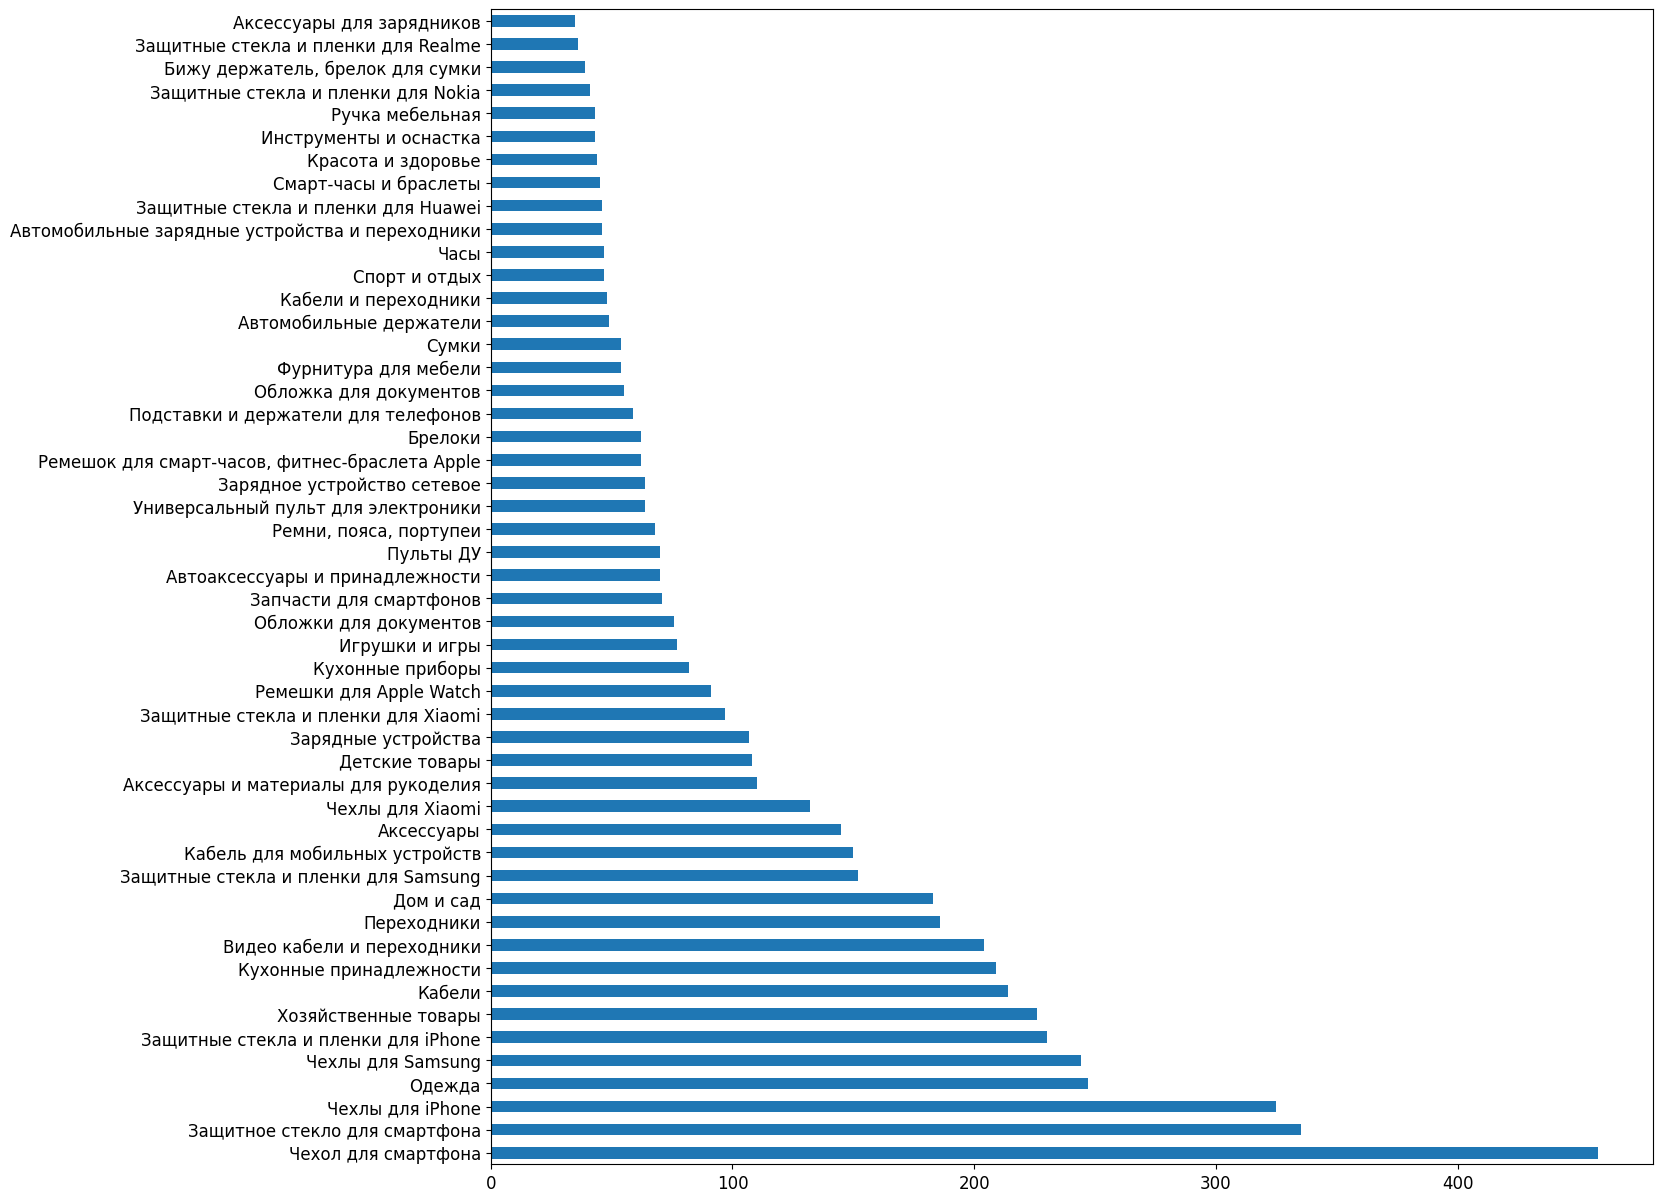

In [94]:
plt.figure(figsize=(15,15))
data['label'].value_counts().sort_values(ascending=False).plot(kind='barh')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

In [95]:
x_train, x_test, y_train, y_test = utils.prepare_data(data, test_size=0.3, remove_stopwords=True, lemmatize=True)

print("Total training examples: ", len(x_train))
print("Total test examples: ", len(x_test))
print(x_train)

description len: 5750
labels len: 5750
Total training examples:  4025
Total test examples:  1725
93      защитный стекло full glue для iphone plus на п...
2022                       умный час smart watch mm серый
4598                     пробка для бутылка с зажим белый
1522          дата кабель usb type c celebrat fly t белый
5732                   чехол силиконовый v для iphone pro
                              ...                        
1645    кожаный чехол leather case для iphone xs max к...
5617    чехол противоударный антишок для samsung galax...
5432    ремешок силиконовый для apple watch mm mm голубой
3769                    набор резинка для волос шт чёрный
1786    лазерный уровень лазерный уровень laser level pro
Name: product_name, Length: 4025, dtype: object


In [96]:
# Word frequency based representation (only unigrams)
xtrain_count, xvalid_count = utils.count_vectorize(x_train, 
                                                   x_test,
                                                   analyzer='word', 
                                                   token_pattern=r'\w{1,}', 
                                                   max_features=10000, 
                                                   ngram_range=(1,1))

# Word frequency based representation (unigrams and bigrams)
xtrain_count_bi, xvalid_count_bi = utils.count_vectorize(x_train, 
                                                         x_test,
                                                         analyzer='word', 
                                                         token_pattern=r'\w{1,}', 
                                                         max_features=10000, 
                                                         ngram_range=(1,2))

xtrain_count_ngram, xvalid_count_ngram = utils.count_vectorize(x_train, 
                                                               x_test,
                                                               analyzer='word', 
                                                               token_pattern=r'\w{1,}', 
                                                               max_features=10000, 
                                                               ngram_range=(1,3))


xtrain_tfidf, xvalid_tfidf = utils.tf_idf_vectorize(x_train, 
                                                    x_test, 
                                                    analyzer='word', 
                                                    token_pattern=r'\w{1,}', 
                                                    max_features=10000, 
                                                    ngram_range=(1,1))


xtrain_tfidf_bi, xvalid_tfidf_bi = utils.tf_idf_vectorize(x_train, 
                                                          x_test, 
                                                          analyzer='word', 
                                                          token_pattern=r'\w{1,}', 
                                                          max_features=10000, 
                                                          ngram_range=(1,2))


xtrain_tfidf_ngram, xvalid_tfidf_ngram = utils.tf_idf_vectorize(x_train, 
                                                                x_test,
                                                                analyzer='word', 
                                                                token_pattern=r'\w{1,}', 
                                                                max_features=10000, 
                                                                ngram_range=(1,3))

xtrain_tfidf_ngram_chars, xvalid_tfidf_ngram_chars = utils.tf_idf_vectorize(x_train, 
                                                                            x_test,
                                                                            analyzer='char', 
                                                                            token_pattern=r'\w{1,}', 
                                                                            max_features=10000, 
                                                                            ngram_range=(2,3))
print("\nPrepared features for Input data")


Prepared features for Input data


In [97]:
# print()

In [98]:
print("\n ----------------------------------- Evaluation on Multinomial Naive Bayes -----------------------------------n\n")
# Naive Bayes on Count Vectors
model1, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(), 
                                        xtrain_count, xvalid_count, 
                                        y_train, y_test)
print("Naive Bayes, Count Vectors: ", accuracy)

# Naive Bayes on bigram Count Vectors
model2, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_count_bi, xvalid_count_bi,
                                        y_train, y_test)
print("\nNaive Bayes, bigram Count Vectors: ", accuracy)

# Naive Bayes on ngram Count Vectors
model3, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_count_ngram, xvalid_count_ngram,
                                        y_train, y_test)
print("\nNaive Bayes, ngram Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
model4, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_tfidf, xvalid_tfidf,
                                        y_train, y_test)
print("\nNaive Bayes, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Word Level bigram TF IDF Vectors
model5, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_tfidf_bi, xvalid_tfidf_bi,
                                        y_train, y_test)
print("\nNaive Bayes, WordLevel bigram TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
model6, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_tfidf_ngram, xvalid_tfidf_ngram,
                                        y_train, y_test)
print("\nNaive Bayes, WordLevel ngram TF-IDF: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
model7, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_tfidf_ngram_chars, xvalid_tfidf_ngram_chars,
                                        y_train, y_test)
print("\nNaive Bayes, CharLevel ngram TF-IDF: ", accuracy)



 ----------------------------------- Evaluation on Multinomial Naive Bayes -----------------------------------n

Naive Bayes, Count Vectors:  0.5257971014492754

Naive Bayes, bigram Count Vectors:  0.5443478260869565

Naive Bayes, ngram Count Vectors:  0.5443478260869565

Naive Bayes, WordLevel TF-IDF:  0.48

Naive Bayes, WordLevel bigram TF-IDF:  0.46492753623188404

Naive Bayes, WordLevel ngram TF-IDF:  0.4834782608695652

Naive Bayes, CharLevel ngram TF-IDF:  0.45217391304347826


In [99]:
count_vect = CountVectorizer(analyzer='word',
                             token_pattern=r'\w{1,}',
                             max_features=10000,
                             ngram_range=(1, 1))
count_vect.fit(x_train)

CountVectorizer(max_features=10000, token_pattern='\\w{1,}')

In [100]:
def lookup(s):
  sus = x_test.iloc[0:1]
  d = {0: s}
  sus = pd.Series(d)
  trans_sus = count_vect.transform(sus)

  predictions = model1.predict(trans_sus)
  predictions = predictions[0]
  res = (data.label.value_counts().iloc[predictions: predictions + 1].keys()[0])
  return res

In [101]:
print(lookup('Заколка клик-клак женская, 1 шт, черная'))
print(lookup('Коврик массажный термопластичная резина, зеленый'))
print(lookup('Велокамера'))
print(lookup('Велокамера 10" 10x.2 125'))
print(lookup('Обучающая игра рыбалка "Водный мир", 12 элементов, 2 удочки'))

Одежда
Переходники
Защитные стекла и пленки для Realme
Защитные стекла и пленки для Realme
Кухонные приборы
